#### Задание

Основные цели этого задания:
- Попрактиковаться в борьбе с дисбалансом классов
- Научиться заполнять пропуски в данных
- Научиться использовать категориальные признаки.\
Задача: по различным признакам, связанным с заявкой на грант, предсказать, будет ли заявка принята. 

In [1]:
#pip install jinja2 missingno category_encoders
#

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, classification_report, make_scorer

from catboost import CatBoostClassifier, Pool

import category_encoders as ce
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

# pd.set_option("display.max_columns", None)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams['font.size'] = 10
plt.style.use('dark_background')


  1. Загрузите данные из csv файла. Ознакомьтесь с ними, проверьте наличие пропусков, узнайте типы признаков.

In [3]:
try:
    df = pd.read_csv('grant_data_imb.csv') 
except FileNotFoundError:
    print("You have to load the file to the directory before opening it.")

In [4]:
df.sample(5)

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
2168,0,4D,10A,NaN,320206.0,100.0,0.0,0.0,0.0,0.0,...,2653.0,25.0,NaN,>=0 to 5,1.0,6.0,5.0,1.0,0.0,0.0
3884,0,2B,10A,NaN,230204.0,40.0,300803.0,30.0,300804.0,30.0,...,3098.0,31.0,Yes,>=0 to 5,1.0,1.0,0.0,15.0,1.0,1.0
1783,0,4D,10A,NaN,270103.0,100.0,0.0,0.0,0.0,0.0,...,NaN,NaN,Yes,NaN,2.0,4.0,4.0,10.0,9.0,1.0
2019,0,4D,10A,NaN,320202.0,100.0,0.0,0.0,0.0,0.0,...,2628.0,25.0,Yes,>=0 to 5,1.0,2.0,8.0,4.0,4.0,2.0
560,0,2B,10A,NaN,380103.0,60.0,380101.0,20.0,320702.0,20.0,...,2558.0,25.0,Yes,>5 to 10,2.0,5.0,3.0,7.0,8.0,0.0


In [5]:
# для удобства работы заменим названия признаков
df.columns = df.columns.str.lower()#.str.replace(".", "_")
df.columns

Index(['grant.status', 'sponsor.code', 'grant.category.code',
       'contract.value.band...see.note.a', 'rfcd.code.1', 'rfcd.percentage.1',
       'rfcd.code.2', 'rfcd.percentage.2', 'rfcd.code.3', 'rfcd.percentage.3',
       'rfcd.code.4', 'rfcd.percentage.4', 'rfcd.code.5', 'rfcd.percentage.5',
       'seo.code.1', 'seo.percentage.1', 'seo.code.2', 'seo.percentage.2',
       'seo.code.3', 'seo.percentage.3', 'seo.code.4', 'seo.percentage.4',
       'seo.code.5', 'seo.percentage.5', 'person.id.1', 'role.1',
       'year.of.birth.1', 'country.of.birth.1', 'home.language.1',
       'dept.no..1', 'faculty.no..1', 'with.phd.1',
       'no..of.years.in.uni.at.time.of.grant.1',
       'number.of.successful.grant.1', 'number.of.unsuccessful.grant.1',
       'a..1', 'a.1', 'b.1', 'c.1'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   grant.status                            4113 non-null   int64  
 1   sponsor.code                            3856 non-null   object 
 2   grant.category.code                     3856 non-null   object 
 3   contract.value.band...see.note.a        1953 non-null   object 
 4   rfcd.code.1                             3853 non-null   float64
 5   rfcd.percentage.1                       3853 non-null   float64
 6   rfcd.code.2                             3853 non-null   float64
 7   rfcd.percentage.2                       3853 non-null   float64
 8   rfcd.code.3                             3853 non-null   float64
 9   rfcd.percentage.3                       3853 non-null   float64
 10  rfcd.code.4                             3853 non-null   floa

Удалим дубликаты, если они есть.

In [7]:
print(f"Количество дубликатов: {df[df.duplicated()].shape[0]}")
df = df.drop_duplicates().reset_index(drop=True)

Количество дубликатов: 65


In [8]:
df.shape

(4048, 39)

In [9]:
# добавим в описание данных столбец с уникальными значениями.
num_feat = df.select_dtypes(include="number")
var_ = num_feat.nunique().to_frame(name="unique")
pd.concat([var_, num_feat.describe().T], join="outer", axis=1)

,unique,count,mean,std,min,25%,50%,75%,max
grant.status,2,4048.0,0.207263,0.405396,0.0,0.0,0.0,0.0,1.0
rfcd.code.1,549,3799.0,314987.705186,47395.004340,210000.0,280401.0,320801.0,321202.0,999999.0
rfcd.percentage.1,21,3799.0,74.569097,26.855677,5.0,50.0,80.0,100.0,100.0
rfcd.code.2,526,3799.0,162425.832061,161657.262975,0.0,0.0,240204.0,320704.0,440207.0
rfcd.percentage.2,19,3799.0,17.726770,19.229527,0.0,0.0,10.0,30.0,90.0
rfcd.code.3,439,3799.0,97265.227428,149011.083605,0.0,0.0,0.0,270304.0,440207.0
rfcd.percentage.3,16,3799.0,7.131614,11.938607,0.0,0.0,0.0,20.0,70.0
rfcd.code.4,75,3799.0,6847.968939,45925.908243,0.0,0.0,0.0,0.0,440105.0
rfcd.percentage.4,11,3799.0,0.442222,3.226775,0.0,0.0,0.0,0.0,70.0
rfcd.code.5,20,3799.0,1793.120558,23764.531159,0.0,0.0,0.0,0.0,419999.0


В числовых данных много пропусков, по большей части столбцов большинство значений находится выше 50% квартиля.

In [10]:
df.describe(include='object').T

,count,unique,top,freq
sponsor.code,3803,226,4D,979
grant.category.code,3803,13,10A,2020
contract.value.band...see.note.a,1931,16,A,951
role.1,4007,7,CHIEF_INVESTIGATOR,3601
country.of.birth.1,3409,10,Australia,2501
home.language.1,389,2,English,312
with.phd.1,2304,1,Yes,2304
no..of.years.in.uni.at.time.of.grant.1,3313,5,>=0 to 5,1321


В категориальных столбцах представлено небольшое кол-во уникальных значений по каждому (кроме sponsor_code).\
Также есть столбец with_phd_1 с одним значением 'Yes'.

Итого в датасете после удаления пропусков 4048 строк и 39 столбоцов, из них 30 - float64, 1 - int64 и 8- object.

#### 2. Подготовьте данные к обучению моделей.

2.1. Отделите целевую переменную Grant.Status.

In [11]:
X = df.drop(columns='grant.status')
y = df['grant.status']

In [12]:
y.isna().sum()

0

In [13]:
y.value_counts()

grant.status
0    3209
1     839
Name: count, dtype: int64

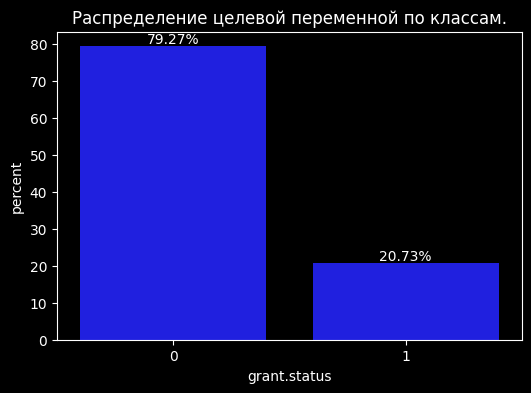

In [14]:
plt.title("Распределение целевой переменной по классам.")
ax = sns.countplot(data=y.to_frame(), x="grant.status", color="blue", stat="percent")
ax.bar_label(ax.containers[0], fmt="%.2f%%")
plt.show()

По целевой переменной наблюдается дисбаланс классов: класса 1 в 4 раза меньше, чем класса 0.

2.2 Предобработайте пропуски в категориальных признаках. Подробнее об этом можно почитать на этой странице документации.

In [15]:
cat_feat = X.select_dtypes(include="object")
cat_feat.isna().sum().to_frame(name='nan')

,nan
sponsor.code,245
grant.category.code,245
contract.value.band...see.note.a,2117
role.1,41
country.of.birth.1,639
home.language.1,3659
with.phd.1,1744
no..of.years.in.uni.at.time.of.grant.1,735


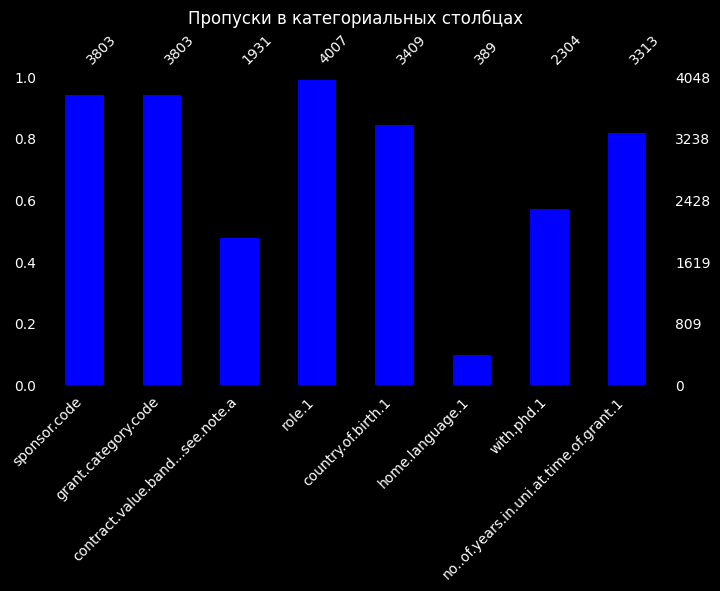

In [16]:
plt.title('Пропуски в категориальных столбцах')
msno.bar(cat_feat, color='blue', figsize=(8,4), fontsize=10)
plt.show()

In [17]:
# check
X.shape

(4048, 38)

Разберем каждый столбец и примем решение, как заполнять пропуски.

In [18]:
X['sponsor.code'].value_counts().to_frame()

,count
sponsor.code,
4D,979
2B,913
21A,374
24D,114
40D,89
...,...
308D,1
284D,1
259C,1


In [19]:
X['grant.category.code'].value_counts().to_frame()

,count
grant.category.code,
10A,2020
30B,699
50A,374
10B,207
20C,177
30C,145
30D,91
20A,48
30G,34


In [20]:
X.loc[(X['sponsor.code'].isna()) & (X['grant.category.code'].notna())]

,sponsor.code,grant.category.code,contract.value.band...see.note.a,rfcd.code.1,rfcd.percentage.1,rfcd.code.2,rfcd.percentage.2,rfcd.code.3,rfcd.percentage.3,rfcd.code.4,...,dept.no..1,faculty.no..1,with.phd.1,no..of.years.in.uni.at.time.of.grant.1,number.of.successful.grant.1,number.of.unsuccessful.grant.1,a..1,a.1,b.1,c.1


Пропуски по этим двум столбцам одинаковые, возможно по ним нет кодов или данные поступили из другого источника.\
Заполним их по умолчанию.

In [21]:
X['contract.value.band...see.note.a'].value_counts().to_frame().T

contract.value.band...see.note.a,A,B,C,D,G,E,F,H,J,I,P,K,M,O,Q,L
count,951,302,156,147,135,97,75,32,18,11,2,1,1,1,1,1


In [22]:
(X["contract.value.band...see.note.a"].isna().sum() / X.shape[0]) * 100

52.297430830039524

В этом столбце много пропусков (52%), заполним по умолчанию.

In [23]:
X["role.1"].value_counts().to_frame()

,count
role.1,
CHIEF_INVESTIGATOR,3601
EXT_CHIEF_INVESTIGATOR,212
PRINCIPAL_SUPERVISOR,141
DELEGATED_RESEARCHER,36
STUD_CHIEF_INVESTIGATOR,10
HONVISIT,6
EXTERNAL_ADVISOR,1


Посмотрим столбцы country_of_birth_1 и home_language_1, по названию между ними должна быть какая-то связь.

In [24]:
X["country.of.birth.1"].value_counts(normalize=True).to_frame()

,proportion
country.of.birth.1,
Australia,0.733646
Great Britain,0.087416
Western Europe,0.045468
Asia Pacific,0.043708
North America,0.035494
Eastern Europe,0.017600
Middle East and Africa,0.011734
The Americas,0.009387
New Zealand,0.009094


Страну можно заменить на самую часто встречающуюся.

In [25]:
X["home.language.1"].value_counts().to_frame()

,count
home.language.1,
English,312
Other,77


In [26]:
(X["home.language.1"].isna().sum() / X.shape[0]) * 100

90.3903162055336

Мы имеем 90% пропусков в данном столбце. Можно посмотреть на его связь с country_of_birth_1.

In [27]:
X.loc[(X["country.of.birth.1"].isna()) & (X["home.language.1"].notna())]

,sponsor.code,grant.category.code,contract.value.band...see.note.a,rfcd.code.1,rfcd.percentage.1,rfcd.code.2,rfcd.percentage.2,rfcd.code.3,rfcd.percentage.3,rfcd.code.4,...,dept.no..1,faculty.no..1,with.phd.1,no..of.years.in.uni.at.time.of.grant.1,number.of.successful.grant.1,number.of.unsuccessful.grant.1,a..1,a.1,b.1,c.1
711,9A,10A,NaN,291803.0,70.0,291801.0,20.0,290201.0,5.0,290501.0,...,2178.0,19.0,Yes,>=0 to 5,0.0,0.0,4.0,1.0,0.0,0.0
2125,210B,30B,A,350107.0,100.0,0.0,0.0,0.0,0.0,0.0,...,1528.0,13.0,NaN,NaN,0.0,1.0,0.0,0.0,1.0,1.0
2219,36D,10A,NaN,300406.0,100.0,0.0,0.0,0.0,0.0,0.0,...,1038.0,1.0,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0
3365,2B,10A,C,280112.0,50.0,280302.0,50.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X.groupby(["country.of.birth.1", "home.language.1"])["home.language.1"].agg("count")

country.of.birth.1      home.language.1
Asia Pacific            English             10
                        Other               13
Australia               English            206
                        Other                3
Eastern Europe          English              7
                        Other                8
Great Britain           English             55
Middle East and Africa  English              1
                        Other                7
North America           English             13
                        Other                1
The Americas            English              9
                        Other                8
Western Europe          English             10
                        Other               34
Name: home.language.1, dtype: int64

На основании данных можно заполнить пропуски по столбцу home_language_1 со значением Great Britain\
в столбце country_of_birth_1.\
Но по сути все пропуски по стране и языку совпадают (кроме 4 строк), можно заполнить их самым частым языком.

In [29]:
# X.loc[X['country.of.birth.1']== 'Great Britain']['home.language.1'].isna().sum()
# X.loc[X["country.of.birth.1"] == "Great Britain", "home.language.1"] = X.loc[
#     X["country.of.birth.1"] == "Great Britain", "home.language.1"
# ].fillna("English")
# (X['home.language.1'].isna().sum()/X.shape[0]) * 100

In [30]:
X['with.phd.1'].value_counts().to_frame()

,count
with.phd.1,
Yes,2304


В столбце with_phd_1 скорее всего пропуски это значения 'No',\
так как phd это ученая степень.\
Этот столбец заполним 'No'.

In [31]:
X["no..of.years.in.uni.at.time.of.grant.1"].value_counts().to_frame()

,count
no..of.years.in.uni.at.time.of.grant.1,
>=0 to 5,1321
>5 to 10,728
Less than 0,492
>10 to 15,413
more than 15,359


Тоже заполним по умолчанию.

Сделаем пайплайн для заполнения пропусков.

In [32]:
imputer_cat_unknown = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Unknown"))]
)

imputer_cat_no = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value="No"))]
)

imputer_cat_country = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)


In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ("imputer_with_phd_1", imputer_cat_no, ["with.phd.1"]),
        ("imputer_counrty", imputer_cat_country, ["country.of.birth.1"]),
        (
            "imputer_categoric",
            imputer_cat_unknown,
            cat_feat.drop(columns=["with.phd.1", "country.of.birth.1"], axis=1).columns,
        ),
    ]
)
preprocessor.fit(X)
X = pd.concat(
    [
        pd.DataFrame(
            preprocessor.transform(X),
            columns=[x.split("__")[-1] for x in preprocessor.get_feature_names_out()],
        ),
        X.select_dtypes(exclude="object"),
    ],
    axis=1,
)

In [34]:
X.shape

(4048, 38)

Проверим результат:

In [35]:
cols_with_missing = [col for col in cat_feat.columns if X[col].isnull().any()]
print("Колонок с пропусками:", len(cols_with_missing))

Колонок с пропусками: 0


In [36]:
X.head()

,with.phd.1,country.of.birth.1,sponsor.code,grant.category.code,contract.value.band...see.note.a,role.1,home.language.1,no..of.years.in.uni.at.time.of.grant.1,rfcd.code.1,rfcd.percentage.1,...,person.id.1,year.of.birth.1,dept.no..1,faculty.no..1,number.of.successful.grant.1,number.of.unsuccessful.grant.1,a..1,a.1,b.1,c.1
0,Yes,Eastern Europe,97A,30B,A,CHIEF_INVESTIGATOR,Unknown,>10 to 15,321024.0,50.0,...,67037.0,1950.0,2563.0,25.0,2.0,6.0,3.0,5.0,15.0,3.0
1,No,Australia,36D,10A,G,PRINCIPAL_SUPERVISOR,Unknown,Less than 0,300201.0,100.0,...,12917.0,1955.0,1038.0,1.0,0.0,3.0,0.0,4.0,0.0,0.0
2,Yes,Great Britain,317A,30D,Unknown,CHIEF_INVESTIGATOR,Unknown,>5 to 10,321013.0,100.0,...,28607.0,1965.0,2763.0,25.0,4.0,3.0,6.0,25.0,14.0,14.0
3,No,Australia,62B,10B,B,CHIEF_INVESTIGATOR,Unknown,Less than 0,321103.0,30.0,...,144632.0,1960.0,2848.0,25.0,1.0,2.0,1.0,0.0,0.0,0.0
4,Yes,North America,1A,10A,Unknown,CHIEF_INVESTIGATOR,Unknown,>5 to 10,270603.0,60.0,...,1797.0,1960.0,2678.0,25.0,5.0,14.0,0.0,9.0,7.0,0.0


2.4. Разделите данные на обучающую и тестовую части.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.3)

#### 3. Обучите модель с помощью библиотеки CatBoost.

Подберите такие гиперпараметры модели, чтобы ее качество (по метрике RocAuc) на валидационной части было не ниже, а лучше и выше качества прогноза, полученного Вами в обычной версии задания, с помощью самостоятельной предобработки данных (от 0.9).

In [38]:
cat_features=cat_feat.columns.to_list()
data_train = Pool(data=X_train, label=y_train, cat_features=cat_features)
data_test = Pool(data=X_test, label=y_test, cat_features=cat_features)

Посмотрим на результат с гиперпараметрами по умолчанию.

In [39]:
model = CatBoostClassifier(
    random_state=123,
    eval_metric="AUC",
    verbose=100,
    od_wait=100,
)
model.fit(
    data_train,
    eval_set=(data_test),
)
y_predict_proba = model.predict_proba(data_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_predict_proba)
print("Roc-auc:", round(roc_auc, 6))
y_pred = model.predict(data_test)
print(classification_report(y_test, y_pred))

Learning rate set to 0.040984
0:	test: 0.8138564	best: 0.8138564 (0)	total: 53.8ms	remaining: 53.7s
100:	test: 0.9408601	best: 0.9408601 (100)	total: 529ms	remaining: 4.7s
200:	test: 0.9412089	best: 0.9414516 (184)	total: 1.02s	remaining: 4.08s
300:	test: 0.9419312	best: 0.9420525 (277)	total: 1.53s	remaining: 3.56s
400:	test: 0.9417492	best: 0.9421397 (361)	total: 2.03s	remaining: 3.04s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9421397049
bestIteration = 361

Shrink model to first 362 iterations.
Roc-auc: 0.94214
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       932
           1       0.83      0.61      0.71       283

    accuracy                           0.88      1215
   macro avg       0.86      0.79      0.82      1215
weighted avg       0.88      0.88      0.87      1215



In [40]:
model = CatBoostClassifier(
    random_state=123,
    # eval_metric="AUC",
    cat_features=cat_features
)

cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# параметры для перебора
param_grid = dict(
    iterations=[100, 200, 361, 500],
    depth=[2, 4],
    nan_mode=["Min", "Max"],
    learning_rate=[0.01, 0.03],
    l2_leaf_reg=[2, 4],
    boosting_type=["Ordered", "Plain"],
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    scoring='roc_auc',
    # refit=True,
    cv=cross_validation,
)

grid_search.fit(X_train, y_train, verbose=0,  plot=True)
print (grid_search.best_score_)
print (grid_search.score(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))
MetricVisualizer(lay

/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/catboost/core.py", line 5220, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, N

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.9346954326465605
0.944115015393015


In [41]:
grid_search.best_params_

{'boosting_type': 'Ordered',
 'depth': 4,
 'iterations': 361,
 'l2_leaf_reg': 4,
 'learning_rate': 0.03,
 'nan_mode': 'Max'}

In [42]:
model = grid_search.best_estimator_
y_predict_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_predict_proba)
print('Roc-auc:', round(roc_auc, 6))
y_pred = model.predict(data_test)
print(classification_report(y_test, y_pred))

Roc-auc: 0.944115
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       932
           1       0.83      0.62      0.71       283

    accuracy                           0.88      1215
   macro avg       0.86      0.79      0.82      1215
weighted avg       0.88      0.88      0.87      1215



2. Напишите вывод, в котором сформулируйте свои наблюдения относительно качества,\
а также времени, необходимом для предобработки данных и обучении модели.

*Вывод:*\
Времени на подготовку данных ушло намного меньше, чем при работе с моделями из sklearn.\
Результат даже без подбора параметров впечатляет: 0.9421\
Лучша модель до этого набрала 0.899017.\
После подбора гиперпараметров результат CatBoost: 0.9441.